# Text generation with a bidirectional LSTM

Today we are looking at how to use a bidirectional Long Short-Term Memory (LSTM) network to generate text. The machine learning library **Tensorflow** is used in this notebook.

## What is an LSTM

An LSTM (Long Short-Term Memory) network is a type of RNNs designed to handle long-term dependencies more effectively than traditional RNNs. It utilizes specialized memory cells to retain and retrieve information over extended sequences, making it ideal for tasks like text generation where understanding context is crucial. In text generation, LSTMs can learn complex patterns within variable-length sequences of text documents, resulting in more coherent and contextually relevant output compared to simpler models like Markov language models.


## The implementation

First we import a text tokenizer to *(drum roll)*... tokenize the text. Why do we need to do this? and what is a corpus? Answer these questions as a written documentation on the code. Print some variables for more understanding.

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer


tokenizer = Tokenizer()
data = open("input.txt", encoding="utf-8").read()
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index)+1
print(total_words)

5801


## Setting up Input Data for Sequential-Pattern Learning

To allow the LSTM to learn the sequential patterns and dependencies present in the text data, the input needs to be presented to the network in a form of n-gram sequences. For example, the sentence "I am studying in Deggendorf" should be turned into ["I", "I am", "I am studying", "I am studying at", "I am studying in Deggendorf"]. The following block does just that.

In [3]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print(input_sequences)

[[34, 132], [34, 132, 2], [34, 132, 2, 777], [34, 132, 2, 777, 20], [34, 132, 2, 777, 20, 29], [34, 132, 2, 777, 20, 29, 1], [34, 132, 2, 777, 20, 29, 1, 314], [2811, 2812], [20, 2813], [18, 777], [3, 2814], [3, 2814, 2], [3, 2814, 2, 2815], [3, 2814, 2, 2815, 20], [3, 2814, 2, 2815, 20, 1], [3, 2814, 2, 2815, 20, 1, 2816], [3, 2814, 2, 2815, 20, 1, 2816, 6], [3, 2814, 2, 2815, 20, 1, 2816, 6, 91], [3, 2814, 2, 2815, 20, 1, 2816, 6, 91, 904], [3, 2814, 2, 2815, 20, 1, 2816, 6, 91, 904, 1836], [3, 2817], [3, 2817, 2], [3, 2817, 2, 2818], [3, 2817, 2, 2818, 2], [3, 2817, 2, 2818, 2, 29], [3, 2817, 2, 2818, 2, 29, 17], [3, 2817, 2, 2818, 2, 29, 17, 2819], [3, 2817, 2, 2818, 2, 29, 17, 2819, 1837], [3, 2817, 2, 2818, 2, 29, 17, 2819, 1837, 20], [3, 2817, 2, 2818, 2, 29, 17, 2819, 1837, 20, 4], [3, 2817, 2, 2818, 2, 29, 17, 2819, 1837, 20, 4, 232], [3, 2817, 2, 2818, 2, 29, 17, 2819, 1837, 20, 4, 232, 6], [2820, 905], [2, 688], [2, 688, 3], [2, 688, 3, 2821], [2, 688, 3, 2821, 2822], [2, 68

## Challenge

If the input list is ["I", "I am", "I am studying", "I am studying at", "I am studying in Deggendorf"] (but tokenized of course), the input items are of different lengths. However, the network needs to be trained with fixed input length.

Complete the following block to pad the items into the same length (i.e., to the max length of input sequences).

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_sequence_length = max(len(sublist) for sublist in input_sequences)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre'))
print(max_sequence_length)

23


## Setting The Target Output

During training, the LSTM model learns to predict the next token (label) based on the context provided by the input sequences (predictors). By iteratively adjusting its internal parameters through backpropagation, the model aims to minimize the categorical cross-entropy loss between its predictions and the actual labels.

* The predictors represent the input sequences used for training the LSTM, providing context for predicting the next token.
* Labels are the target tokens to predict.

In [5]:
import tensorflow.keras.utils as keras_utils

predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = keras_utils.to_categorical(label, num_classes=total_words)

## The Model

The following block presents a sequential model with a unidirectional LSTM stacked on top of a bidirectional LSTM.

* If a tokenized input sequence is [1, 2, 3], does the +1 increment mean something? Hint: this is one of the reasons behind adding a word embedding layer.
* A bidirectional LSTM with 150 memory units is added. Why 150? and why is `return_sequences=True`?
* Before adding a unidirectional LSTM on top of the bidirectional one, a `Dropout` layer is placed. Why?
* Two `Dense` layers are added after the unidirectional LSTM: one is halved in neuron numbers, with a ReLU activation, and a regulizer; the other is set up with softmax activation. Explain roughly and shortly for each the reason behind their use and setup.



In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import regularizers


model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_length-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(150))
model.add(Dense(int(total_words/2), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.save('model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Training

The model is simply fit with the inputs and their expected outputs to be trained.

Epoch 1/50
1275/1275 [==============================] - 46s 30ms/step - loss: 6.6783 - accuracy: 0.0544
Epoch 2/50
1275/1275 [==============================] - 21s 17ms/step - loss: 6.2738 - accuracy: 0.0569
Epoch 3/50
1275/1275 [==============================] - 20s 16ms/step - loss: 6.1091 - accuracy: 0.0627
Epoch 4/50
1275/1275 [==============================] - 20s 16ms/step - loss: 5.9837 - accuracy: 0.0760
Epoch 5/50
1275/1275 [==============================] - 21s 16ms/step - loss: 5.8705 - accuracy: 0.0873
Epoch 6/50
1275/1275 [==============================] - 20s 16ms/step - loss: 5.7528 - accuracy: 0.0972
Epoch 7/50
1275/1275 [==============================] - 20s 15ms/step - loss: 5.6349 - accuracy: 0.1066
Epoch 8/50
1275/1275 [==============================] - 20s 16ms/step - loss: 5.5233 - accuracy: 0.1127
Epoch 9/50
1275/1275 [==============================] - 20s 15ms/step - loss: 5.4241 - accuracy: 0.1201
Epoch 10/50
1275/1275 [==============================] - 20s 15m

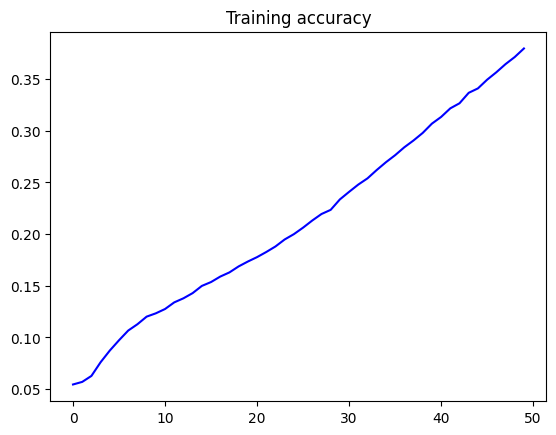

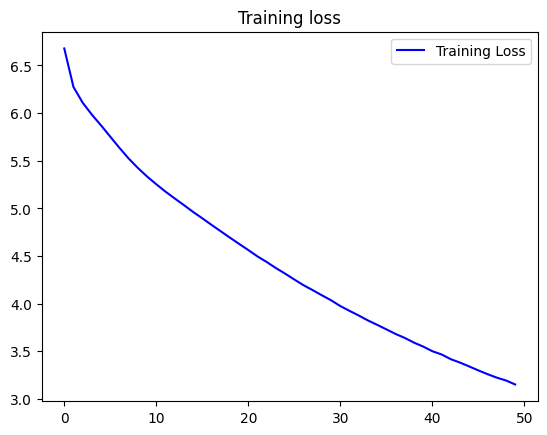

In [7]:
history = model.fit(predictors, label, epochs=50, verbose=1)

import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()


## Generating Text

Fill in the missing variables in the following block and let the model generate some words. Play with the previous parameters (training epochs, memory units, removing the unidirectional LSTM or any additional layer,...) and try to spot the deviations.

In [8]:
seed_text = 'so long and '
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
    predicted_probabilities = model.predict(token_list, verbose=0)
    predicted_class = np.argmax(predicted_probabilities)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted_class:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

so long and  thanks for the time to say no' to fall down the galaxy and then noncommittally and watched the time to say it was a little nervous again as if you would excite avoided simultaneously so it was a little stiffly slim next driver placidly as he was going to be able to move that if there was a little nervous again and then noncommittally at all the first thing to say to the ground and the whole circus would smithers like something to say i'd been startled to say it gets to him and what's you to say it was
